In [ ]:
! pip install -q pyhessian functorch
#change to cuda=True in Hessian if cuda

In [ ]:
import torch
import numpy as np
import torch.nn as nn
from torch.nn import init
import torch.optim as optim
import torch.nn.functional as F 
import random
import math
import copy
import time
import pickle
from IPython.display import clear_output

import matplotlib.pylab as plt
import matplotlib.gridspec as gridspec
from pyhessian import hessian

# Vision
#import torchvision
#import torchvision.transforms as T
#import torchvision.datasets as dset

from torch.utils.data import Dataset, DataLoader
from torch.utils.data import sampler


USE_GPU = True

dtype = torch.float32 

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print('using device:', device)

from google.colab import drive
drive.mount('/content/gdrive')


using device: cuda
Mounted at /content/gdrive


In [ ]:
#this remove for test
# def test_loss(model, loader_test):
#     #criterion2 = nn.CrossEntropyLoss()
#     criterion1 = nn.MSELoss()
#     loss = 0
#     for x,y in loader_test:
#         model.eval()  # put model to training mode
#         model = model.to(device=device)
#         x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
#         y = y.to(device=device, dtype=torch.long)
#         #two lines below refer to loss choice of criterion2
#         #scores = model(x).squeeze() 
#         #loss += criterion2(scores, y) 
#         #lines below refer to loss choice of criterion1
#         scores = model(x)
#         loss += criterion1(scores, y.to(device=device, dtype=dtype))
#         #loss += criterion1(scores, F.one_hot(y,num_classes=p).to(device=device, dtype=dtype))
#         ##hessian_comp = hessian(model, criterion1, data=(x, y.to(device=device, dtype=dtype)), cuda=True)
#         ##top_eigenvalues, top_eigenvector = hessian_comp.eigenvalues(top_n=1)
#         ##trace = np.mean(hessian_comp.trace())
#     return loss#*frac/(1-frac)##, top_eigenvalues, trace


            #loss = criterion2(scores.squeeze(), y)

# def check_accuracy(loader, model):
#     num_correct = 0
#     num_samples = 0
#     model = model.to(device=device)
#     model.eval()  # set model to evaluation mode
#     x_wrong = []
#     with torch.no_grad():
#         for x, y in loader:
            
#             x = x.to(device=device, dtype=dtype)  
#             y = y.to(device=device, dtype=torch.long)
            
#             scores = model(x) 
#             _, preds = scores.max(1)
#             preds = preds.reshape(len(preds), 1)
            
#             num_correct += (preds == y).sum()
#             num_samples += preds.size(0)
#             x_wrong.append(x[ y != preds])
            
#         acc = float(num_correct) / num_samples

#     return num_correct.data, num_samples, acc


def trainer(model, optimizer, epochs, time1, loader_train, plot_timesteps):#, loader_test): this remove for test
    # Make data dic, contains training data
    data = {'loss' :[], 'test_loss': [], 'ws':[], 'test_acc':[], 'train_acc': [], 'gradfc1':[], 'gradfc2':[], 'fc1.ws':[], 'fc2.ws':[],
            'train_topeigs': [], 'test_topeigs': [], 'train_trace': [], 'test_trace': []}
    
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    criterion1 = nn.MSELoss()
    #criterion2 = nn.CrossEntropyLoss()
    stopwatch = 0
    for e in range(epochs):
      
        #print("EPOCH: ", e)

        for t, (x, y) in enumerate(loader_train):
            
            model.train()  # put model to training mode

            model = model.to(device=device)
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)

            ####

            scores = model(x)
            loss = criterion1(scores, y.to(device=device, dtype=dtype))
            #loss = criterion1(scores, F.one_hot(y,num_classes=p).to(device=device, dtype=dtype))

            #loss = criterion2(scores.squeeze(), y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            #scheduler.step()

            if e % plot_timesteps == 0 and t ==0:
              data['gradfc1'].append((model.fc1.weight.grad**2).mean().detach().clone().cpu())
              data['gradfc2'].append((model.fc2.weight.grad**2).mean().detach().clone().cpu())
              
              # Use Pyheessian package
              # ################################
              hessian_comp = hessian(model, criterion1, data=(x, y.to(device=device, dtype=dtype)), cuda=False)
              # hessian_comp = hessian(model, criterion2, data=(x, y), cuda=True)
              top_eigenvalues, top_eigenvector = hessian_comp.eigenvalues(top_n=1)
              trace = np.mean(hessian_comp.trace())
              # hessian = hessian_fn(model, criterion1, x, F.one_hot(y,num_classes=59))
              # print(hessian.shape)              
              
              ##t_loss, t_eigs, t_trace = test_loss(model, loader_test)
              #t_loss = test_loss(model, loader_test)
              #data['test_loss'].append(t_loss.detach().clone().cpu())
              ##data['test_topeigs'].append(np.array(t_eigs))
              ##data['test_trace'].append(t_trace)              
              with torch.no_grad():
                #data['test_acc'].append((check_accuracy(loader_test, model)[2]*100))
                #data['train_acc'].append((check_accuracy(loader_train, model)[2]*100))
                #this below remove for test
                #data['test_loss'].append(test_loss(model, loader_test).detach().clone().cpu())
                data['loss'].append(loss.detach().clone().cpu())
                data['fc1.ws'].append((model.fc1.weight**2).mean().detach().clone().cpu())
                data['fc2.ws'].append((model.fc2.weight**2).mean().detach().clone().cpu())
                data['train_topeigs'].append(np.array(top_eigenvalues))
                data['train_trace'].append(trace) 
            
            if e % 100 == 0 and t==0:
              with torch.no_grad():
                end1 = time.time()
                #sys.stdout.write(f'Epoch {(e+1)} / {epochs}, Top eig = {top_eigenvalues}, Time: {end1-start} s')
                #sys.stdout.write('\b')
                #sys.stdout.flush()
                clear_output()
                print(f'Epoch {(e+1)} / {epochs}, Top eig = {top_eigenvalues}, Time: {end1-start} s')#.item()
                
                #print(f'Test acc: {check_accuracy(loader_test, model)[2]*100}% correctly')
                #print(f'Train acc: {check_accuracy(loader_train, model)[2]*100}% correctly')
                
                #print("Time:", (end1-start), "s")

            
            

            
                
              
    return data

In [ ]:
################ MLP model #################
def flatten(x):
  N = x.shape[0] # read in N, C, H, W
  return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image

class fcc(nn.Module):
  def __init__(self, in_size, h_size, out_size):
    super(fcc, self).__init__()

    self.in_size = in_size
    self.h_size = h_size
    self.out_size = out_size

    self.fc1 = nn.Linear(in_size, h_size, bias=False)
    self.fc2 = nn.Linear(h_size, h_size, bias=False)
    self.fc3 = nn.Linear(h_size, h_size, bias=False)
    self.fc4 = nn.Linear(h_size, h_size, bias=False)
    self.fc5 = nn.Linear(h_size, h_size, bias=False)
    self.fc6 = nn.Linear(h_size, h_size, bias=False)
    self.fc7 = nn.Linear(h_size, h_size, bias=False)
    self.fc8 = nn.Linear(h_size, h_size, bias=False)
    self.fc9 = nn.Linear(h_size, h_size, bias=False)
    self.fc10 = nn.Linear(h_size, h_size, bias=False)
    self.fc11 = nn.Linear(h_size, h_size, bias=False)
    self.fc12 = nn.Linear(h_size, h_size, bias=False)
    self.fc13 = nn.Linear(h_size, h_size, bias=False)
    self.fc14 = nn.Linear(h_size, h_size, bias=False)
    self.fc15 = nn.Linear(h_size, h_size, bias=False)
    self.fc16 = nn.Linear(h_size, h_size, bias=False)
    self.fc17 = nn.Linear(h_size, h_size, bias=False)
    self.fc18 = nn.Linear(h_size, h_size, bias=False)
    self.fc19 = nn.Linear(h_size, h_size, bias=False)
    self.fc20 = nn.Linear(h_size, out_size, bias=False)


    #torch.nn.init.normal_(self.fc1.weight, mean=0.0, std=1.0)
    #torch.nn.init.normal_(self.fc2.weight, mean=0.0, std=1.0)
    #torch.nn.init.normal_(self.fc3.weight, mean=0.0, std=1.0)
    #torch.nn.init.normal_(self.fc4.weight, mean=0.0, std=1.0)
    #torch.nn.init.normal_(self.fc5.weight, mean=0.0, std=1.0)
    torch.nn.init.xavier_uniform_(self.fc1.weight)
    torch.nn.init.xavier_uniform_(self.fc2.weight)
    torch.nn.init.xavier_uniform_(self.fc3.weight)
    torch.nn.init.xavier_uniform_(self.fc4.weight)
    torch.nn.init.xavier_uniform_(self.fc5.weight)
    torch.nn.init.xavier_uniform_(self.fc6.weight)
    torch.nn.init.xavier_uniform_(self.fc7.weight)
    torch.nn.init.xavier_uniform_(self.fc8.weight)
    torch.nn.init.xavier_uniform_(self.fc9.weight)
    torch.nn.init.xavier_uniform_(self.fc10.weight)
    torch.nn.init.xavier_uniform_(self.fc11.weight)
    torch.nn.init.xavier_uniform_(self.fc12.weight)
    torch.nn.init.xavier_uniform_(self.fc13.weight)
    torch.nn.init.xavier_uniform_(self.fc14.weight)
    torch.nn.init.xavier_uniform_(self.fc15.weight)
    torch.nn.init.xavier_uniform_(self.fc16.weight)
    torch.nn.init.xavier_uniform_(self.fc17.weight)
    torch.nn.init.xavier_uniform_(self.fc18.weight)
    torch.nn.init.xavier_uniform_(self.fc19.weight)
    torch.nn.init.xavier_uniform_(self.fc20.weight)

  def forward(self, x):
    # ModuleList can act as an iterable, or be indexed using ints
    # First layer
    x = flatten(x)
    x = self.fc1(x) #* math.sqrt(2 / self.in_size) 
    #x = torch.relu(x)
    x = self.fc2(x) #* math.sqrt(2 / self.h_size)
    #x = torch.relu(x)
    x = self.fc3(x) #* math.sqrt(2 / self.h_size)
    #x = torch.relu(x)
    x = self.fc4(x) #* math.sqrt(2 / self.h_size)
    #x = torch.relu(x)
    x = self.fc5(x) #* math.sqrt(2 / self.h_size)
    #x = torch.relu(x)
    x = self.fc6(x) #* math.sqrt(2 / self.in_size) 
    #x = torch.relu(x)
    x = self.fc7(x) #* math.sqrt(2 / self.h_size)
    #x = torch.relu(x)
    x = self.fc8(x) #* math.sqrt(2 / self.h_size)
    #x = torch.relu(x)
    x = self.fc9(x) #* math.sqrt(2 / self.h_size)
    #x = torch.relu(x)
    x = self.fc10(x) #* math.sqrt(2 / self.h_size)
    #x = torch.relu(x)
    x = self.fc11(x) #* math.sqrt(2 / self.in_size) 
    #x = torch.relu(x)
    x = self.fc12(x) #* math.sqrt(2 / self.h_size)
    #x = torch.relu(x)
    x = self.fc13(x) #* math.sqrt(2 / self.h_size)
    #x = torch.relu(x)
    x = self.fc14(x) #* math.sqrt(2 / self.h_size)
    #x = torch.relu(x)
    x = self.fc15(x) #* math.sqrt(2 / self.h_size)
    #x = torch.relu(x)
    x = self.fc16(x) #* math.sqrt(2 / self.in_size) 
    #x = torch.relu(x)
    x = self.fc17(x) #* math.sqrt(2 / self.h_size)
    #x = torch.relu(x)
    x = self.fc18(x) #* math.sqrt(2 / self.h_size)
    #x = torch.relu(x)
    x = self.fc19(x) #* math.sqrt(2 / self.h_size)
    #x = torch.relu(x)
    x = self.fc20(x) #* math.sqrt(2 / self.h_size)
    #x = torch.relu(x)
    return x

In [ ]:
lr1 = 2/150
epochs = 50000
plot_timesteps = 30
time1 = 1000000000


dataset_size=50
d_in=50
d_out=50
d_hidden=50

torch.manual_seed(0)
np.random.seed(1)
random.seed(2)


###SETTING UP TRAINING AND TEST SET

frac = 1.0 # training set is frac * total set

X= np.random.normal(loc=0,scale=1.0,size=(dataset_size, d_in))
Q,_ = np.linalg.qr(X)
X=(dataset_size)**(0.5)*Q
#Avec=[(d_in-i)/d_in for i in range(d_in)]
#A=np.diag(Avec)
A = np.random.normal(loc=0,scale=1.0,size=(d_in, d_in))
Y=X@A
#Y= np.random.normal(loc=1,scale=0.0,size=(dataset_size, d_out))

m = Y.shape[0]


### Dataset and loader ###
class Modular(torch.utils.data.Dataset):
    
    # Constructor
    def __init__(self, data, labels):
        self.x = data
        self.y = labels
        self.N = self.x.shape[0]
        
    # Getter
    def __getitem__(self, index):    
        return self.x[index,:], self.y[index]
    
    # Get length
    def __len__(self):
        return self.N
        
with torch.no_grad():
    samples = Modular(X, Y)

train_size = int(frac * m)
test_size = m - train_size # between 1 and m
loader_train = DataLoader(samples, batch_size = int(train_size/1), shuffle=False, drop_last=False,
                    sampler=sampler.SubsetRandomSampler(range(0, train_size)))




###TRAIN

start = time.time()

for lr in [lr1]:
  for wd in [0]:

    Student = fcc(d_in, d_hidden, d_out)

    ### Swith off the decoder ###
    #Student.fc2.weight.requires_grad=True
    #Student.fc1.weight.requires_grad=False
    #Student.Wout.requires_grad=False

    #AdamW = optim.AdamW(Student.parameters(), lr=1e-1, betas=(0.9, 0.98), eps=1e-08, weight_decay=0.1, amsgrad=False, maximize=False, foreach=None, capturable=False)
    #LLR = optim.lr_scheduler.LambdaLR(SGD, lambda step: min(1, 1))

    SGD = optim.SGD(Student.parameters(), lr, momentum = 0, weight_decay=0)
    

    train_data = trainer(model = Student, optimizer = SGD, epochs = epochs, time1=time1,
                          loader_train = loader_train, plot_timesteps=plot_timesteps )#, loader_test = loader_test) this remove for test

    loss = np.array(train_data['loss'])
    #these two remove for test
    #loss_test = np.array(train_data['test_loss'])
    #test_acc = np.array(train_data['test_acc'])
    train_acc = np.array(train_data['train_acc'])
    train_eigs = np.array(train_data['train_topeigs'])
    ##test_eigs = np.array(train_data['test_topeigs'])
    train_trace = np.array(train_data['train_trace'])
    ##test_trace = np.array(train_data['test_trace'])


    #plt.figure(1, figsize=(15,7))
    #plt.plot(epochvec, loss,'-')

    epochvec=[i*plot_timesteps for i in range(loss.shape[0])]
    
    fig, axs = plt.subplots(1, 3, figsize=(18, 4))
    axs[0].plot(epochvec,loss)
    axs[1].plot(epochvec,train_eigs)
    axs[2].plot(epochvec,train_trace)
    #this remove for test
    #plt.figure(1, figsize=(15,7))
    #plt.plot(loss_test, label=f'wd: {wd}, lr: {lr}')
    #plt.legend()

    #plt.figure(2, figsize=(15,7))
    #plt.plot(train_acc, label=f'wd: {wd}, lr: {lr}')
    #plt.legend()

    #plt.figure(2, figsize=(15,7))
    #plt.plot(test_acc, label=f'wd: {wd}, lr: {lr}')
    #plt.legend()

    #plt.figure(3, figsize=(15,7))
    #plt.plot(train_eigs, label=f'wd: {wd}, lr: {lr}')
    #plt.legend()

    plt.show()

    progress = {'lr' : lr, 'times' : epochvec,'loss' : loss, 'sharpness' : train_eigs.reshape(-1,train_eigs.shape[0])[0], 'trace' : train_trace.reshape(-1,train_trace.shape[0])[0]}
      

    #print('loss=',loss)
    #print('sharp=',train_eigs.reshape(-1,train_eigs.shape[0])[0])
    #print('trace=',train_trace.reshape(-1,train_trace.shape[0])[0])


/usr/local/lib/python3.8/dist-packages/torch/autograd/__init__.py:197: UserWarning: Using backward() with create_graph=True will create a reference cycle between the parameter and its gradient which can cause a memory leak. We recommend using autograd.grad when creating the graph to avoid this. If you have to use this function, make sure to reset the .grad fields of your parameters to None after use to break the cycle and avoid the leak. (Triggered internally at ../torch/csrc/autograd/engine.cpp:1059.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


RuntimeError: ignored

In [ ]:
    with open('/content/gdrive/My Drive/Colab Notebooks/Edge of Stability/DeepLinear.txt', 'rb') as handle:
      progress_list = pickle.load(handle)
    progress_list=np.append(progress_list,progress)
    with open('/content/gdrive/My Drive/Colab Notebooks/Edge of Stability/DeepLinear.txt', 'wb') as handle:
      pickle.dump(progress_list, handle, protocol=pickle.HIGHEST_PROTOCOL)  

In [ ]:
with open('/content/gdrive/My Drive/Colab Notebooks/Edge of Stability/DeepLinear.txt', 'rb') as handle:
    prog_list = pickle.load(handle)
len(prog_list)

24

Position: 22 / 24, LR = 0.01, 2/LR: 200.0


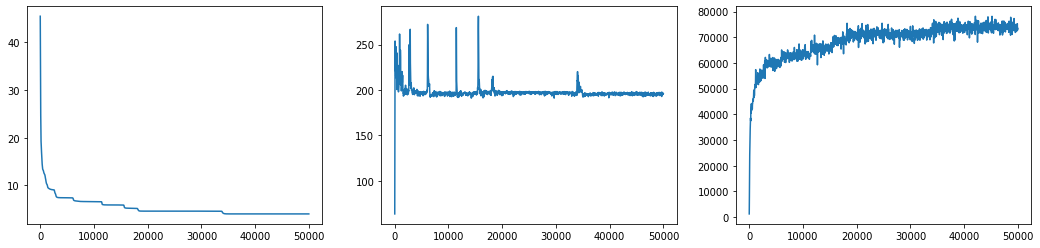

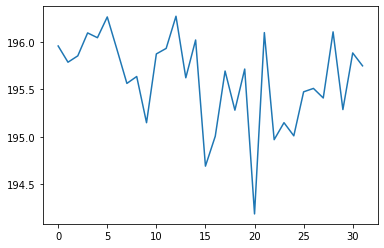

In [ ]:
nn1=22
lrr1=prog_list[nn1]['lr']
print(f'Position: {nn1} / {len(prog_list)}, LR = { lrr1 }, 2/LR: {2/lrr1}')
fig, axs = plt.subplots(1, 3, figsize=(18, 4))
axs[0].plot(prog_list[nn1]['times'],prog_list[nn1]['loss'])
axs[1].plot(prog_list[nn1]['times'],prog_list[nn1]['sharpness'])
axs[2].plot(prog_list[nn1]['times'],prog_list[nn1]['trace'])
plt.show()
delta=5
avg=[sum(prog_list[nn1]['sharpness'][i*delta:(i+1)*delta])/delta for i in range(int(prog_list[nn1]['sharpness'].shape[0]/delta))]
plt.plot(avg[300:-1])

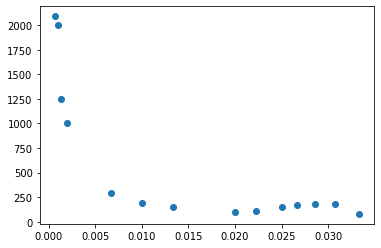

In [ ]:
results=[[2/90,110],[2/75,168],[2/65,185],[2/80,150],[2/60,80],[2/70,180],[2/100,100],[2/300,295],[2/3000,2090],[2/2000,2000],[2/1500,1250],
         [2/1000,1000],[2/150,147],[2/200,195]]
resLR=[results[i][0] for i in range(len(results))]
resSH=[results[i][1] for i in range(len(results))]
plt.plot(resLR,resSH,'o')

In [ ]:
2/150

0.013333333333333334

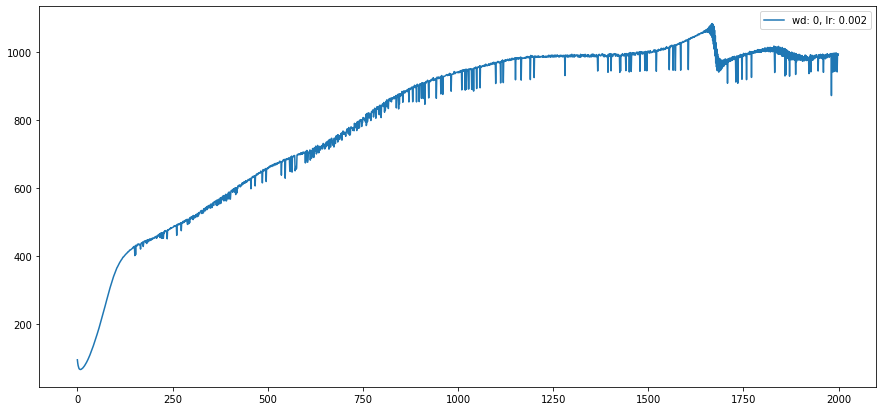

In [ ]:
    #this is with same deep linear model as in Cohen et al
    plt.figure(3, figsize=(15,7))
    plt.plot(train_eigs, label=f'wd: {wd}, lr: {lr}')
    plt.legend()

In [ ]:
#Initialize file
progress_list=[]
with open('/content/gdrive/My Drive/Colab Notebooks/Edge of Stability/DeepLinear.txt', 'wb') as handle:
    pickle.dump(progress_list, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
#@title Block for generating train/test datasets


### Generate dataset for modular addition ###

dataset_size=50
d_in=50
d_out=50
d_hidden=50
frac = 1.0 # training set is frac * total set

np.random.seed(1)
X= np.random.normal(loc=0,scale=1.0,size=(dataset_size, d_in))
Q,_ = np.linalg.qr(X)
X=(dataset_size)**(0.5)*Q
#Avec=[(d_in-i)/d_in for i in range(d_in)]
#A=np.diag(Avec)
A = np.random.normal(loc=0,scale=1.0,size=(d_in, d_in))
Y=X@A
#Y= np.random.normal(loc=1,scale=0.0,size=(dataset_size, d_out))

m = Y.shape[0]


### Dataset and loader ###
class Modular(torch.utils.data.Dataset):
    
    # Constructor
    def __init__(self, data, labels):
        self.x = data
        self.y = labels
        self.N = self.x.shape[0]
        
    # Getter
    def __getitem__(self, index):    
        return self.x[index,:], self.y[index]
    
    # Get length
    def __len__(self):
        return self.N
        
with torch.no_grad():
    samples = Modular(X, Y)

### Loader ###


train_size = int(frac * m)
test_size = m - train_size # between 1 and m
print(f'total: {m}, test: {test_size}, train: {train_size}')


loader_train = DataLoader(samples, batch_size = int(train_size/1), shuffle=False, drop_last=False,
                    sampler=sampler.SubsetRandomSampler(range(0, train_size)))

#loader_test = DataLoader(samples, batch_size = test_size , shuffle=False, drop_last=False,
#                    sampler=sampler.SubsetRandomSampler(range(train_size, m)))

for x,y in loader_train:
    print(x.shape, y.shape)


total: 50, test: 0, train: 50
torch.Size([50, 50]) torch.Size([50, 50])
